## Artículos Interesantes

Veamos acá cómo está distribuido el odio según las notas

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

540


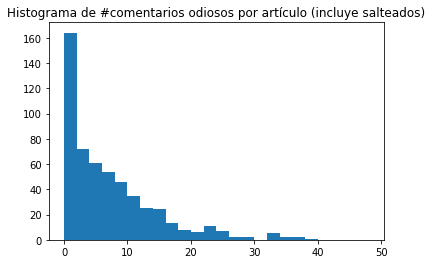

In [3]:
from matplotlib import pyplot as plt

hist = []
users = ["asilva", "dvalado", "gclerici", "gdamill", "lprats", ]

article_labels = ArticleLabel.objects.prefetch_related('comment_labels').filter(
    user__username__in=users,
    
).exclude(
    article__batch__name="training"
)

label_stats = {
    
}

for article_label in article_labels:
    hateful_comments = sum([c.is_hateful for c in article_label.comment_labels.all()])
    label_stats[article_label] = hateful_comments
    
plt.hist(label_stats.values(), bins=range(0, 50, 2), range=[0, 50])
plt.title("Histograma de #comentarios odiosos por artículo (incluye salteados)")
print(len(label_stats))

Y si vemos el máximo por cada artículo?

total = 306


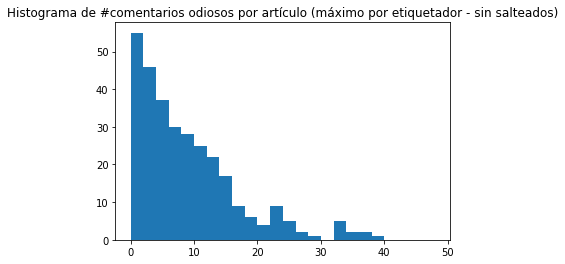

In [8]:
article_stats = {
    
}

was_skipped = set()

for article_label in article_labels:
    article = article_label.article
    
    if not article_label.is_interesting:
        was_skipped.add(article)
        continue
        
    hateful_comments = sum([c.is_hateful for c in article_label.comment_labels.all()])
    
    article_stats[article] = max(
        article_stats.get(article, 0),
        hateful_comments,
    )

plt.hist(article_stats.values(), bins=range(0, 50, 2), range=[0, 50])
plt.title("Histograma de #comentarios odiosos por artículo (máximo por etiquetador - sin salteados)")
print(f"total = {len(article_stats)}")

Los comentarios de <= 3 comentarios odiosos son muchos (los dos primeros bins)

Veamos qué pasa ahí

In [9]:
not_so_terrible = [article for article, hateful_comments in article_stats.items() if hateful_comments <= 3]

not_so_terrible = sorted(not_so_terrible, key=lambda x: article_stats[x])
print(len(not_so_terrible))

for article in not_so_terrible:
    print("="*80)
    print(article.title, "\n")
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )


    for label in hateful_labels:
        print(label, end="\n\n")


101
Matías Lammens: "Los tripulantes de Aerolíneas Argentinas están haciendo patria" 

Sergio Berni y la Policía Bonaerense creen que Facundo Astudillo Castro murió en un accidente 

Marcelo Tinelli respondió preguntas de sus seguidores y confirmó que no vuelve a la televisión hasta 2021 

Alfredo Cornejo: “El peronismo de hoy representa al sector parasitario que vive de quienes crean riqueza” 

Eduardo Feinmann tiene coronavirus 

Raúl Zaffaroni: “Los medios cumplen la función de un partido único, como el de Hitler” 

Mauricio Macri rompió el silencio: "Vienen desplegando un ataque sistemático a la Constitución" 

Nuevo banderazo en contra del Gobierno nacional en distintas ciudades del país 

Escándalo en el Congreso: escena sexual del diputado kirchnerista Juan Emilio Ameri en plena sesión virtual 

Coronavirus en Argentina: largas colas para ingresar a Pinamar y Gesell, pese a los pedidos de aislamiento 

Coronavirus: según un estudio, los perros callejeros podrían estar en el orig

Veamos los que tienen 4 o 5

In [10]:
some_articles = [article for article, hateful_comments in article_stats.items() if 4 <= hateful_comments <= 5]

some_articles = sorted(some_articles, key=lambda x: article_stats[x])
print(len(some_articles))

for article in some_articles:
    print("="*80)
    print(article.title, "\n") 
    print(f"Artículos marcados como posiblemente odiosos = {article_stats[article]}\n\n")
    
    print("Etiquetas")
    print("---------\n")
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )


    for label in hateful_labels:
        print(label, end="\n\n")


37
Coronavirus: la OMS viaja a China y empieza a estudiar la nueva gripe porcina 

Artículos marcados como posiblemente odiosos = 4


Etiquetas
---------

asilva sobre '@usuario Confirmado los chinos son culpables de todos los males. por favor aislenlos del mundo en forma inmediata.'
Odioso y violento  -> ['RACISMO']

dvalado sobre '@usuario Confirmado los chinos son culpables de todos los males. por favor aislenlos del mundo en forma inmediata.'
Odioso y violento  -> ['RACISMO']

dvalado sobre '@usuario son TODOS UNOS HIJOS DE PUTA, TANTO CHINOS, ONU Y OMS. POR LA MATANZA DE BILLONES DE ANIMALES'
Odioso  -> ['RACISMO']

dvalado sobre '@usuario Me parece q NU y la OMS ya tendrían q ocuparse seriamente de China. Es un territorio inmenso con 1400 millones de personas q propagan cualquier cosa en días. Con unas costumbres alimenticias q demostraron ser peligrosísimas. No somos mejores pero parece que ahí hay un plus.'
Odioso  -> ['RACISMO']

asilva sobre '@usuario Manden a los chinos a ma

## Ideas

Las que tienen 4 o 5 parecen más interesantes.

Si un artículo lo marcan dos, y como máximo hay 3 comentarios odiosos => descartar

Ahora, veamos qué pasó con los salteos


# Salteados

In [11]:
len(was_skipped)

91

¿Cuántos artículos fueron salteados pero también etiquetados por otro etiquetador?

In [14]:
skipped_and_annotated = [article for article in was_skipped if article in article_stats]

print(f"Hay {len(skipped_and_annotated)} artículos que fueron anotados y salteados a la vez ")

Hay 58 artículos que fueron anotados y salteados a la vez 


(array([ 9., 14., 11., 11.,  4.,  5.,  1.,  1.,  0.,  2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

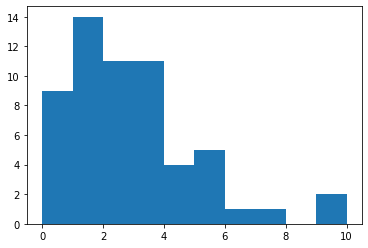

In [17]:
skipped_stats = [article_stats[art] for art in skipped_and_annotated]

plt.hist(skipped_stats, range=[0, 10], bins=10)

¿Cuántos comentarios habría que reanotar?

In [18]:
sum(skipped_stats)

141

Pocos, pero dale que va.

Fijémonos que la mayoría tienen <= 3 comentarios odiosos

In [39]:
Article.objects.filter(labels__is_interesting=False).distinct().count()

101

In [35]:
for art in sorted(skipped_and_annotated, key=lambda x: article_stats[x]):
    skipped = art.labels.filter(is_interesting=False)
    annotated = art.labels.filter(is_interesting=True)
    print("="*80)
    print(art.title, "\n")
    
    print(article_stats[art], " comentarios odiosos")
    print(f"Anotaron : {' - '.join(label.user.username for label in annotated)}")
    print(f"Saltearon: {' - '.join(label.user.username for label in skipped)}")

Escándalo en el Congreso: escena sexual del diputado kirchnerista Juan Emilio Ameri en plena sesión virtual 

0  comentarios odiosos
Anotaron : gclerici
Saltearon: dvalado
Alberto Fernández: “Querían salir a correr y a pasear, salgan, ahí están las consecuencias” 

0  comentarios odiosos
Anotaron : lprats
Saltearon: dvalado
Raúl Zaffaroni: “Los medios cumplen la función de un partido único, como el de Hitler” 

0  comentarios odiosos
Anotaron : gclerici
Saltearon: dvalado
Mauricio Macri rompió el silencio: "Vienen desplegando un ataque sistemático a la Constitución" 

0  comentarios odiosos
Anotaron : gclerici
Saltearon: dvalado
Carlitos Balá, el hombre que regala risas y cosecha afecto cumple 95 años 

0  comentarios odiosos
Anotaron : lprats
Saltearon: dvalado
Coronavirus: según un estudio, los perros callejeros podrían estar en el origen de la pandemia 

0  comentarios odiosos
Anotaron : lprats
Saltearon: dvalado
El desgarrador mensaje de una enferma de cáncer que está sin medicació

In [19]:
print(f"Artículos salteados = {len(was_skipped)}")
for article in sorted(skipped_and_annotated, key=lambda x: article_stats[x]):
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )
    if hateful_labels.count() == 0:
        continue
    print("="*80)
    print(article.title, "\n") 
    print(f"Artículos marcados como posiblemente odiosos = {article_stats[article]}\n\n")
    
    print("Etiquetas")
    print("---------\n")
    

    for label in hateful_labels:
        print(label, end="\n\n")

Artículos salteados = 91
Reestructuración en Coca-Cola: la empresa desmiente un traslado de sus operaciones en Argentina en medio de rumores 

Artículos marcados como posiblemente odiosos = 1


Etiquetas
---------

asilva sobre '@usuario Suele pasar que las empresas ven zurdos y huyen despavoridos. En fin, triste por los argentinos que a penas inician en el viaje largo y horroroso al desastre y la desolacion.'
Odioso  -> ['POLITICA']

La OMS pidió ahora evitar las cuarentenas como método principal para controlar el avance del coronavirus 

Artículos marcados como posiblemente odiosos = 1


Etiquetas
---------

asilva sobre '@usuario La droga que consumen es legal? Que manga de hdp'
Odioso  -> ['DISCAPACIDAD']

Coronavirus en Argentina: volvían de Brasil y cambiaron los carteles de los micros para evitar la cuarentena, pero fueron detenidos 

Artículos marcados como posiblemente odiosos = 1


Etiquetas
---------

gclerici sobre '@usuario Tienen mierda en la cabeza y estoy segura que est